## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# from keras.layers import Dropout

# """
# 建立神經網路，並加入 dropout layer
# """
# def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
#     input_layer = keras.layers.Input(input_shape)
    
#     for i, n_units in enumerate(num_neurons):
#         if i == 0:
#             x = keras.layers.Dense(units=n_units, 
#                                    activation="relu", 
#                                    name="hidden_layer"+str(i+1))(input_layer)
#             x = Dropout(drp_ratio)(x)
#         else:
#             x = keras.layers.Dense(units=n_units, 
#                                    activation="relu", 
#                                    name="hidden_layer"+str(i+1))(x)
#             x = Dropout(drp_ratio)(x)
    
#     out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
#     model = keras.models.Model(inputs=[input_layer], outputs=[out])
#     return model

In [7]:
# from keras.layers import BatchNormalization

# def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
#     input_layer = keras.layers.Input(input_shape)
    
#     for i, n_units in enumerate(num_neurons):
#         if i == 0:
#             x = keras.layers.Dense(units=n_units, 
#                                    activation="relu", 
#                                    name="hidden_layer"+str(i+1))(input_layer)
#             x = BatchNormalization()(x)
#         else:
#             x = keras.layers.Dense(units=n_units, 
#                                    activation="relu", 
#                                    name="hidden_layer"+str(i+1))(x)
#             x = BatchNormalization()(x)
    
#     out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
#     model = keras.models.Model(inputs=[input_layer], outputs=[out])
#     return model

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE_ = [128, 256]
MOMENTUM = 0.95
L2_EXP = [1e-4, 1e-8]
Dropout_EXP_ = [0.2, 0.3]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio_2 in L2_EXP:
    for Dropout_EXP in Dropout_EXP_:
        for BATCH_SIZE in BATCH_SIZE_:

            keras.backend.clear_session() # 把舊的 Graph 清掉
            #print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
            model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio_2, drp_ratio=Dropout_EXP)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "l2:{}_drp:{}_batch:{}".format(regulizer_ratio_2, Dropout_EXP, BATCH_SIZE)
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.4254 - acc: 0.9052 - val_loss: 2.7717 - val_acc: 0.4616
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____

Epoch 49/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.3232 - acc: 0.9479 - val_loss: 2.5608 - val_acc: 0.4692
Epoch 50/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.3206 - acc: 0.9495 - val_loss: 2.4999 - val_acc: 0.4759
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024     

Epoch 48/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.4524 - acc: 0.8925 - val_loss: 2.5190 - val_acc: 0.4725
Epoch 49/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.4335 - acc: 0.8993 - val_loss: 2.6533 - val_acc: 0.4452
Epoch 50/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.4427 - acc: 0.8965 - val_loss: 2.5610 - val_acc: 0.4531
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131

50000/50000 [==============================] - 3s 63us/step - loss: 0.3500 - acc: 0.9378 - val_loss: 2.4863 - val_acc: 0.4707
Epoch 47/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.3394 - acc: 0.9419 - val_loss: 2.5143 - val_acc: 0.4710
Epoch 48/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.3262 - acc: 0.9476 - val_loss: 2.4659 - val_acc: 0.4657
Epoch 49/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.3127 - acc: 0.9531 - val_loss: 2.4221 - val_acc: 0.4773
Epoch 50/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.2971 - acc: 0.9580 - val_loss: 2.5691 - val_acc: 0.4558
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               157

50000/50000 [==============================] - 4s 88us/step - loss: 0.3117 - acc: 0.8964 - val_loss: 2.5068 - val_acc: 0.4529
Epoch 46/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.3015 - acc: 0.8988 - val_loss: 2.3547 - val_acc: 0.4638
Epoch 47/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.3008 - acc: 0.8954 - val_loss: 2.3013 - val_acc: 0.4755
Epoch 48/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.2989 - acc: 0.8968 - val_loss: 2.4988 - val_acc: 0.4524
Epoch 49/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.2994 - acc: 0.8972 - val_loss: 2.3924 - val_acc: 0.4740
Epoch 50/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.2826 - acc: 0.9016 - val_loss: 2.6055 - val_acc: 0.4434
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)           

50000/50000 [==============================] - 3s 63us/step - loss: 0.2427 - acc: 0.9277 - val_loss: 2.4072 - val_acc: 0.4572
Epoch 45/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.2298 - acc: 0.9329 - val_loss: 2.2966 - val_acc: 0.4664
Epoch 46/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.2205 - acc: 0.9359 - val_loss: 2.4435 - val_acc: 0.4677
Epoch 47/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.2129 - acc: 0.9378 - val_loss: 2.2917 - val_acc: 0.4652
Epoch 48/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.1909 - acc: 0.9468 - val_loss: 2.3249 - val_acc: 0.4735
Epoch 49/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.1863 - acc: 0.9469 - val_loss: 2.4124 - val_acc: 0.4677
Epoch 50/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.1681 - acc: 0.9545 - val_loss: 2.4780 - val_acc: 0.4661
______________________________________________

50000/50000 [==============================] - 4s 87us/step - loss: 0.3310 - acc: 0.8862 - val_loss: 2.2073 - val_acc: 0.4771
Epoch 44/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.3210 - acc: 0.8910 - val_loss: 2.6283 - val_acc: 0.4408
Epoch 45/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.3217 - acc: 0.8893 - val_loss: 2.3504 - val_acc: 0.4708
Epoch 46/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.3202 - acc: 0.8894 - val_loss: 2.3766 - val_acc: 0.4514
Epoch 47/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.3029 - acc: 0.8943 - val_loss: 2.3976 - val_acc: 0.4787
Epoch 48/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.2855 - acc: 0.9014 - val_loss: 2.3732 - val_acc: 0.4746
Epoch 49/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.2714 - acc: 0.9086 - val_loss: 2.3821 - val_acc: 0.4762
Epoch 50/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 0.2609 - acc: 0.9210 - val_loss: 2.3154 - val_acc: 0.4691
Epoch 43/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.2507 - acc: 0.9244 - val_loss: 2.2027 - val_acc: 0.4683
Epoch 44/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.2310 - acc: 0.9320 - val_loss: 2.1792 - val_acc: 0.4744
Epoch 45/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.2198 - acc: 0.9354 - val_loss: 2.3224 - val_acc: 0.4677
Epoch 46/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.2093 - acc: 0.9413 - val_loss: 2.4718 - val_acc: 0.4684
Epoch 47/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.1959 - acc: 0.9444 - val_loss: 2.3360 - val_acc: 0.4741
Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.1944 - acc: 0.9442 - val_loss: 2.4248 - val_acc: 0.4738
Epoch 49/50
50000/50000 [=====================

In [10]:
# for Dropout_EXP in Dropout_EXP_:
#     for optimizer in OPT_:
#         keras.backend.clear_session() # 把舊的 Graph 清掉
#         #print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
#         model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP)
#         model.summary()
#         #optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
#         #optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False)
#         if optimizer == keras.optimizers.SGD:
#             model.compile(loss="categorical_crossentropy", metrics=["accuracy"], \
#                           optimizer=optimizer(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM))
#         else:
#             model.compile(loss="categorical_crossentropy", metrics=["accuracy"], \
#                           optimizer=optimizer(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False))

#         model.fit(x_train, y_train, 
#                   epochs=EPOCHS, 
#                   batch_size=BATCH_SIZE, 
#                   validation_data=(x_test, y_test), 
#                   shuffle=True)

#         # Collect results
#         train_loss = model.history.history["loss"]
#         valid_loss = model.history.history["val_loss"]
#         train_acc = model.history.history["acc"]
#         valid_acc = model.history.history["val_acc"]

#         exp_name_tag = "dropout rate:{}".format(Dropout_EXP)
#         results[exp_name_tag] = {'train-loss': train_loss,
#                                  'valid-loss': valid_loss,
#                                  'train-acc': train_acc,
#                                  'valid-acc': valid_acc}

In [11]:
# for BATCH_SIZE in BATCH_SIZE_:
#     keras.backend.clear_session() # 把舊的 Graph 清掉
#     #print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
#     model = build_mlp(input_shape=x_train.shape[1:])
#     model.summary()
#     optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
#     model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
#     model.fit(x_train, y_train, 
#               epochs=EPOCHS, 
#               batch_size=BATCH_SIZE, 
#               validation_data=(x_test, y_test), 
#               shuffle=True)

#     # Collect results
#     train_loss = model.history.history["loss"]
#     valid_loss = model.history.history["val_loss"]
#     train_acc = model.history.history["acc"]
#     valid_acc = model.history.history["val_acc"]

#     exp_name_tag = "batch size:{}".format(BATCH_SIZE)
#     results[exp_name_tag] = {'train-loss': train_loss,
#                              'valid-loss': valid_loss,
#                              'train-acc': train_acc,
#                              'valid-acc': valid_acc}

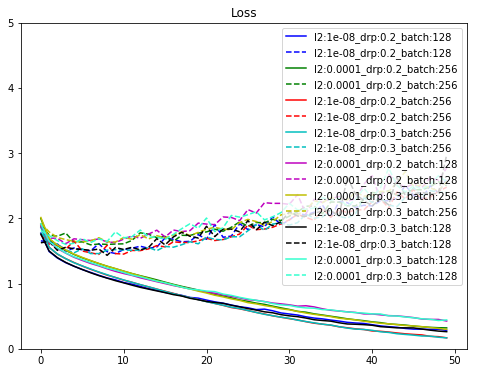

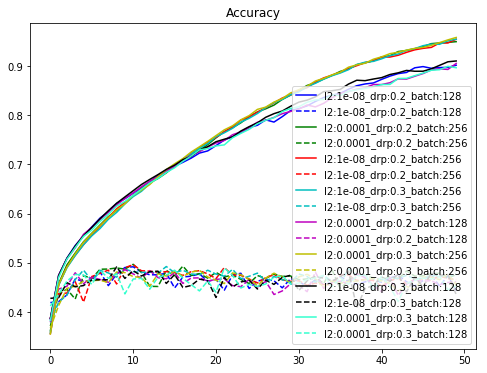

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["b", "g", "r", "c", "m", "y", "k", "#33FFCE"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()